In [1]:
#Importing required librabries
import pyspark.pandas as ps
import numpy as np
import matplotlib as plt
import pandas as pd

C:\Apps\spark-3.4.0-bin-hadoop3\python\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
# List of Required Columns
columns = ['request_datetime', 'on_scene_datetime', 'pickup_datetime',       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay']
#,       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',       'wav_request_flag', 'wav_match_flag']

In [3]:
#Reading Zones data for join
Data = pd.read_csv('final_df.csv', low_memory=False)

In [4]:
Data.head()

,Unnamed: 0,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,LocationID_x,PUL_Zone,LocationID_y,DOL_Zone,PUL_Zone_to_DOL_Zone
0,0,2023-02-01 00:12:17,2023-02-01 00:13:34,2023-02-01 00:15:34,2023-02-01 00:25:01,244,74,5.410,567,16.45,...,1.16,0.0,0.0,0.0,12.82,244,Washington Heights South,74,East Harlem North,Washington Heights South-East Harlem North
1,1,2023-02-01 00:54:30,2023-02-01 00:56:08,2023-02-01 00:58:08,2023-02-01 01:13:51,244,74,5.030,943,17.55,...,1.56,0.0,0.0,0.0,14.98,244,Washington Heights South,74,East Harlem North,Washington Heights South-East Harlem North
2,2,2023-02-01 00:43:55,2023-02-01 00:45:20,2023-02-01 00:47:13,2023-02-01 00:56:56,244,74,5.070,583,16.07,...,1.43,0.0,0.0,0.0,14.49,244,Washington Heights South,74,East Harlem North,Washington Heights South-East Harlem North
3,3,2023-02-01 00:27:38,NaN,2023-02-01 00:30:25,2023-02-01 00:38:14,244,74,3.152,469,11.26,...,1.02,0.0,0.0,0.0,9.46,244,Washington Heights South,74,East Harlem North,Washington Heights South-East Harlem North
4,4,2023-02-01 00:28:58,NaN,2023-02-01 00:32:48,2023-02-01 00:39:27,244,74,2.417,399,10.61,...,0.94,0.0,0.0,0.0,6.73,244,Washington Heights South,74,East Harlem North,Washington Heights South-East Harlem North


In [5]:
#Importing Libraries we will use for data processing and ML model 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import time
from IPython.display import clear_output

In [6]:
# Checking the number of rows and columns
Data.shape

(17960971, 22)

In [7]:
# Looking for null values in each row 
Data.isnull().sum()

Unnamed: 0                    0
request_datetime              0
on_scene_datetime       4673541
pickup_datetime               0
dropoff_datetime              0
PULocationID                  0
DOLocationID                  0
trip_miles                    0
trip_time                     0
base_passenger_fare           0
tolls                         0
bcf                           0
sales_tax                     0
congestion_surcharge          0
airport_fee                   0
tips                          0
driver_pay                    0
LocationID_x                  0
PUL_Zone                    890
LocationID_y                  0
DOL_Zone                 682678
PUL_Zone_to_DOL_Zone     683292
dtype: int64

In [8]:
# Dropping rows with null values
data = Data.dropna()

In [9]:
del Data

In [10]:
# This command will supress warning raised when chained assignments are used
pd.options.mode.chained_assignment = None

In [11]:
data.columns

Index(['Unnamed: 0', 'request_datetime', 'on_scene_datetime',
       'pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID',
       'trip_miles', 'trip_time', 'base_passenger_fare', 'tolls', 'bcf',
       'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips',
       'driver_pay', 'LocationID_x', 'PUL_Zone', 'LocationID_y', 'DOL_Zone',
       'PUL_Zone_to_DOL_Zone'],
      dtype='object')

In [12]:
#Converting pickup datetime and dropoff datetime to datetime format 
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [13]:
# Creating new columns named weekday number and pickup hour
data['weekday_num'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour

DATA CLEANING

In [ ]:
zone_counts = data.groupby(['PUL_Zone_to_DOL_Zone','DOL_Zone']).size().unstack()
#Select top 10 'sourceIps' values with the highest counts
top10_zones = zone_counts.sum(axis=1).nlargest(10).index

In [ ]:
# Filtering the data with passengers more than zero and less than nine
data = data[data['PUL_Zone_to_DOL_Zone'].isin(top10_zones)]

In [19]:
data.columns

Index(['Unnamed: 0', 'request_datetime', 'on_scene_datetime',
       'pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID',
       'trip_miles', 'trip_time', 'base_passenger_fare', 'tolls', 'bcf',
       'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips',
       'driver_pay', 'LocationID_x', 'PUL_Zone', 'LocationID_y', 'DOL_Zone',
       'PUL_Zone_to_DOL_Zone', 'weekday_num', 'pickup_hour', 'total_amount'],
      dtype='object')

In [16]:
data['total_amount'] = data['base_passenger_fare'] + data['tolls'] + data['bcf'] + data['sales_tax'] + data['sales_tax'] + data['congestion_surcharge'] + data['airport_fee'] + data ['tips'] + data['driver_pay']

In [17]:
# Filtering the data with trip distance greater than zero
data = data[data['trip_miles']>=0]

In [18]:
# Filtering the data with trip duration greater than zero
data = data[data['trip_time']>=0]

In [ ]:
#Creating dummy variables for 'HTTP Method','time_period','Resource' variables==============(By Rahul Agarwal)
data1 = pd.get_dummies(data, columns=['ZonePU-DP'])

In [20]:
# Droping columns which are not necessary for The ML models
data1=data.drop(['Unnamed: 0','on_scene_datetime','pickup_datetime','dropoff_datetime','request_datetime','base_passenger_fare', 'tolls', 'bcf',
       'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips',
       'driver_pay', 'LocationID_x', 'PUL_Zone', 'LocationID_y', 'DOL_Zone',
       'PUL_Zone_to_DOL_Zone'], axis=1)

In [21]:
# Quick look at the Data
data1.head(10)

,PULocationID,DOLocationID,trip_miles,trip_time,weekday_num,pickup_hour,total_amount
0,244,74,5.41,567,2,0,31.98
1,244,74,5.03,943,2,0,36.18
2,244,74,5.07,583,2,0,33.90
6,244,74,3.99,581,2,4,28.24
7,244,74,3.38,657,2,5,31.11
10,244,74,3.24,678,2,6,29.40
11,244,74,3.66,1110,2,7,35.61
12,244,74,2.51,1102,2,7,42.84
14,244,74,4.06,1885,2,7,54.94
15,244,74,3.89,1446,2,7,53.71


In [22]:
# Looking at the data types
data1.dtypes

PULocationID      int64
DOLocationID      int64
trip_miles      float64
trip_time         int64
weekday_num       int64
pickup_hour       int64
total_amount    float64
dtype: object

ML USE CASE

We will try and predict the taxi fares for the ride depending on the day and time of the ride and also the Pickup and drop off location IDs and trip distance

In [23]:
#Spliting the data into test and train
# We are going to use trip distance, PULocationID, DOLocationID, Weekday number and Pickup Hour as the feature elements to predict Taxi fares
# passenger_count,PULocationID,DOLocationID,weekday_num,pickup_hour
x = data1.iloc[:, [0,1,2,3,4,5]].values
y = data1.iloc[:,6].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state = 7294)

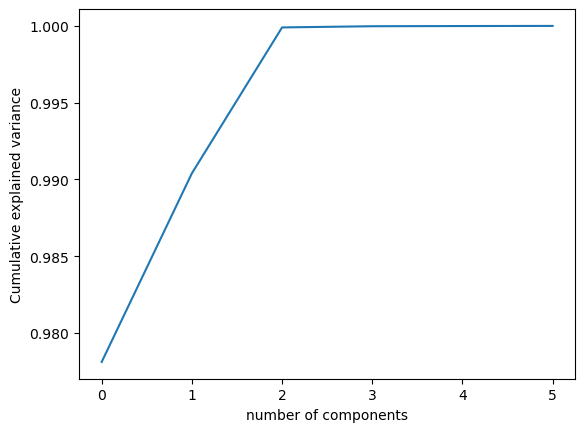

In [24]:
# Uisng PCA to determine necessary number of components for the model to yeild a better result
from sklearn.decomposition import PCA
pca = PCA().fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [25]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

[(1, 97.81),
 (2, 99.04),
 (3, 99.99000000000001),
 (4, 100.00000000000001),
 (5, 100.00000000000001)]

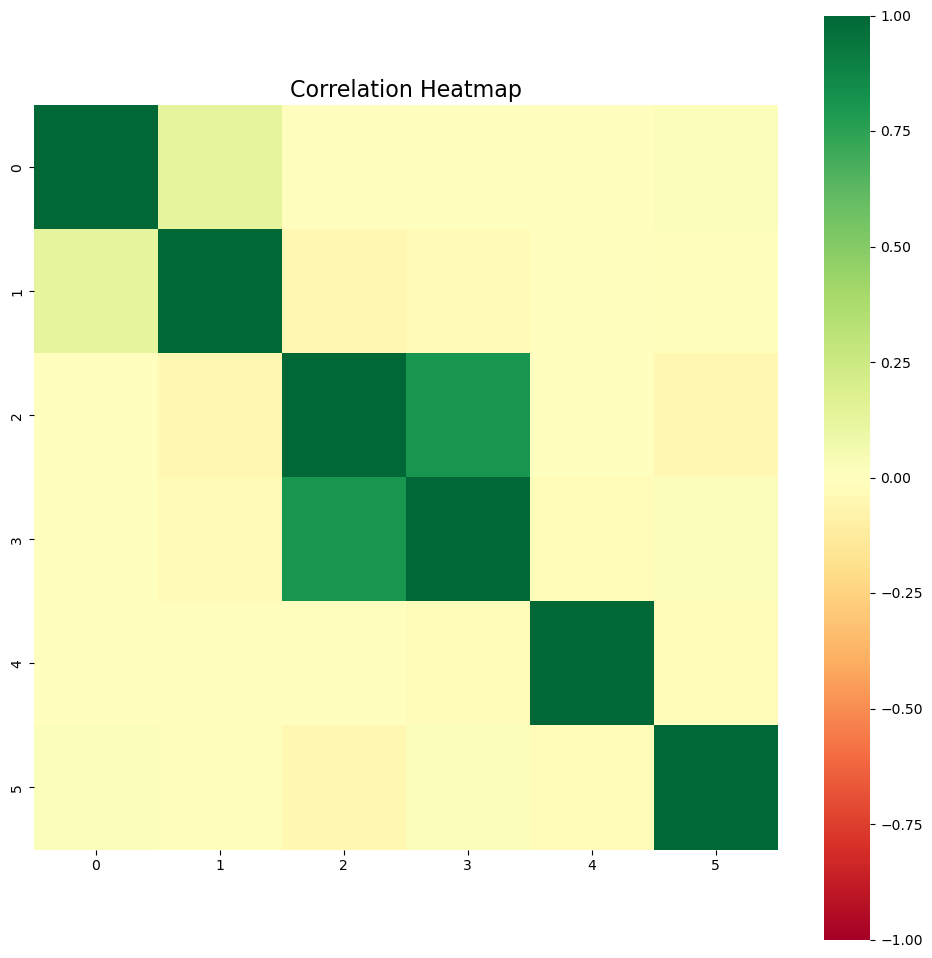

In [26]:
# Plotting the heatmap to understand the correlation between the factors

plt.figure(figsize=(12,12))
corr = pd.DataFrame(x_train[:,0:]).corr()
corr.index = pd.DataFrame(x_train[:,0:]).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [27]:
# Running The Linear regression model
start_time = time.time()
lm_regression = LinearRegression()
lm_regression = lm_regression.fit(x_train, y_train)
end_time = time.time()
lm_time = (end_time - start_time)
print(f"Time taken to train linear regression model : {lm_time} seconds")

Time taken to train linear regression model : 2.307380437850952 seconds


In [28]:
lm_regression_trips = lm_regression.predict(x_test)

In [29]:
# Generating prediction for Linear Regression model
predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': lm_regression_trips.flatten()})
predictions

,Actual,Predicted
0,38.10,46.059519
1,24.19,24.389734
2,36.35,34.731754
3,23.37,25.307870
4,25.69,32.782064
...,...,...
2557898,29.00,33.148645
2557899,22.18,24.709217
2557900,21.16,24.059083
2557901,14.46,12.053712


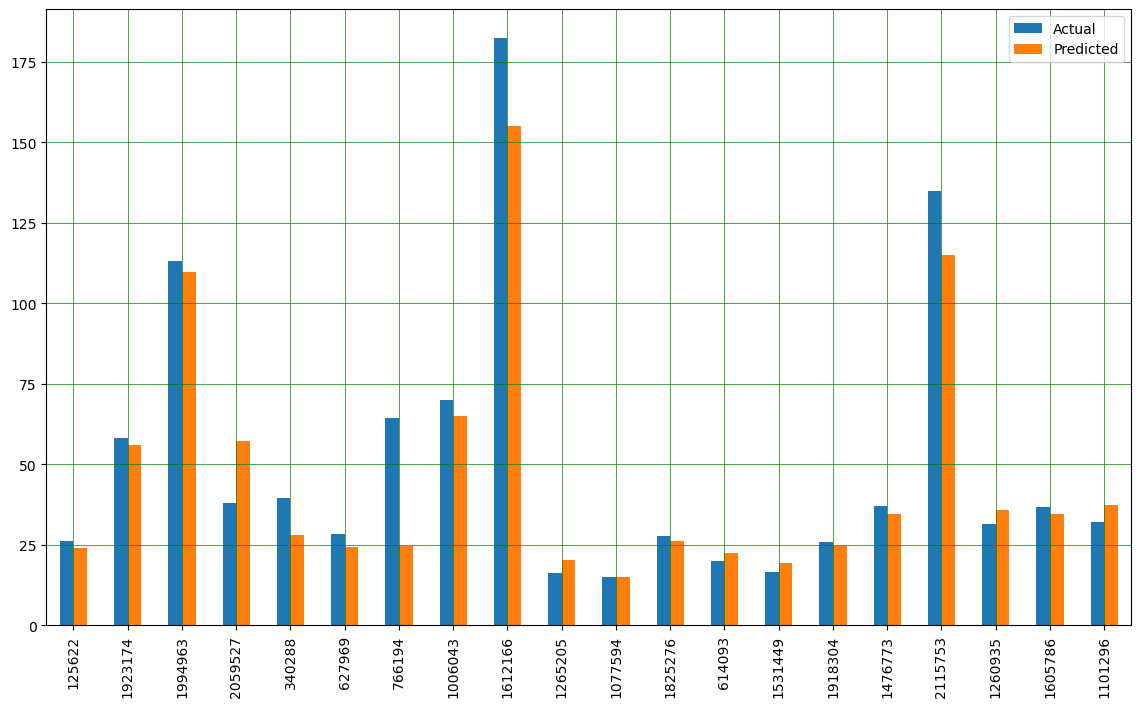

In [30]:
#Plotting Actuall vs Predicted Values
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [31]:
#Getting The R Squared Value
lm_score = r2_score(y_test, lm_regression_trips)
print(lm_score)

0.8546116135900236


In [32]:
# Running the Decision Tree Regressor
start_time = time.time()
dt_regression = DecisionTreeRegressor()
dt_regression = dt_regression.fit(x_train, y_train)
end_time = time.time()
dt_time = (end_time - start_time)
print(f"Time taken to train Decision tree model : {dt_time} seconds")

Time taken to train Decision tree model : 90.06848382949829 seconds


In [33]:
dt_regression_trips = dt_regression.predict(x_test)

In [34]:
# Generating prediction for Decission Tree Regressor model
predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': dt_regression_trips.flatten()})
predictions

,Actual,Predicted
0,38.10,41.65
1,24.19,27.31
2,36.35,35.50
3,23.37,23.77
4,25.69,25.63
...,...,...
2557898,29.00,25.83
2557899,22.18,18.10
2557900,21.16,21.76
2557901,14.46,15.01


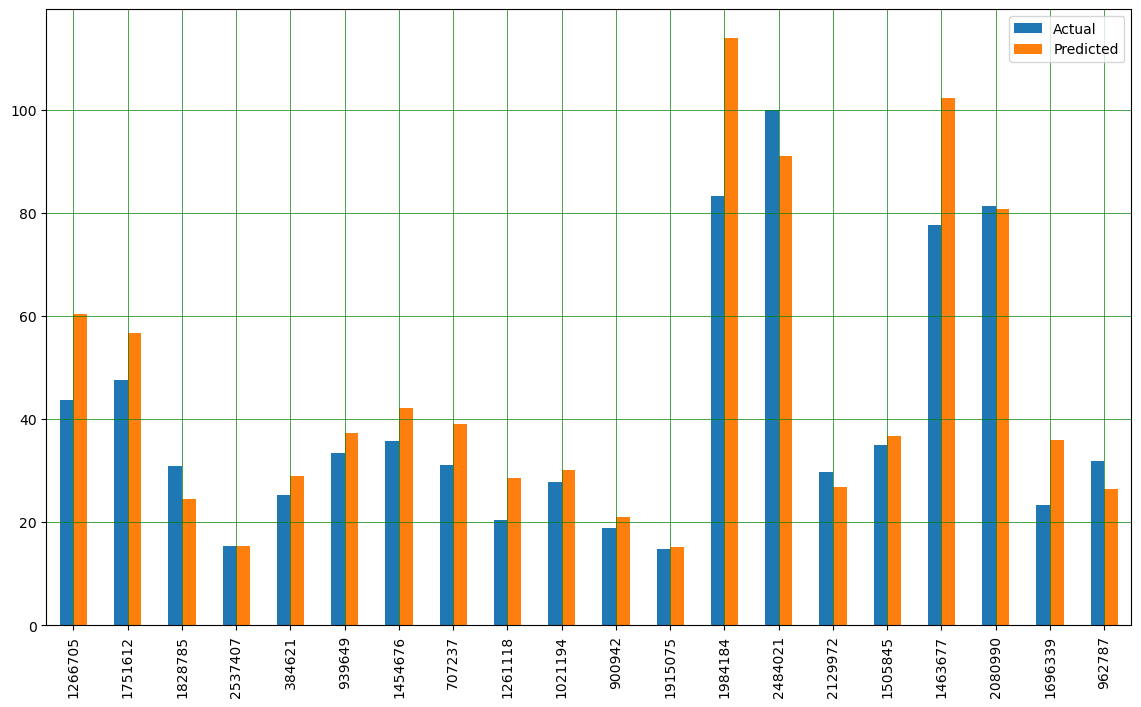

In [35]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [36]:
#Getting The R Squared Value
dt_score = r2_score(y_test, dt_regression_trips)
print(dt_score)

0.7646756159427249


In [37]:
# Running The AdaBoostRegressor model
start_time = time.time()
ada_regression = AdaBoostRegressor()
ada_regression = ada_regression.fit(x_train, y_train)
end_time = time.time()
ad_time = (end_time - start_time)
print(f"Time taken to train AdaBoost model : {ad_time} seconds")

Time taken to train AdaBoost model : 333.1220588684082 seconds


In [38]:
ada_trips = ada_regression.predict(x_test)

In [39]:
predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': ada_trips.flatten()})
predictions

,Actual,Predicted
0,38.10,32.816921
1,24.19,27.627255
2,36.35,31.895046
3,23.37,31.895046
4,25.69,32.816921
...,...,...
2557898,29.00,31.895046
2557899,22.18,27.627255
2557900,21.16,30.690695
2557901,14.46,27.627255


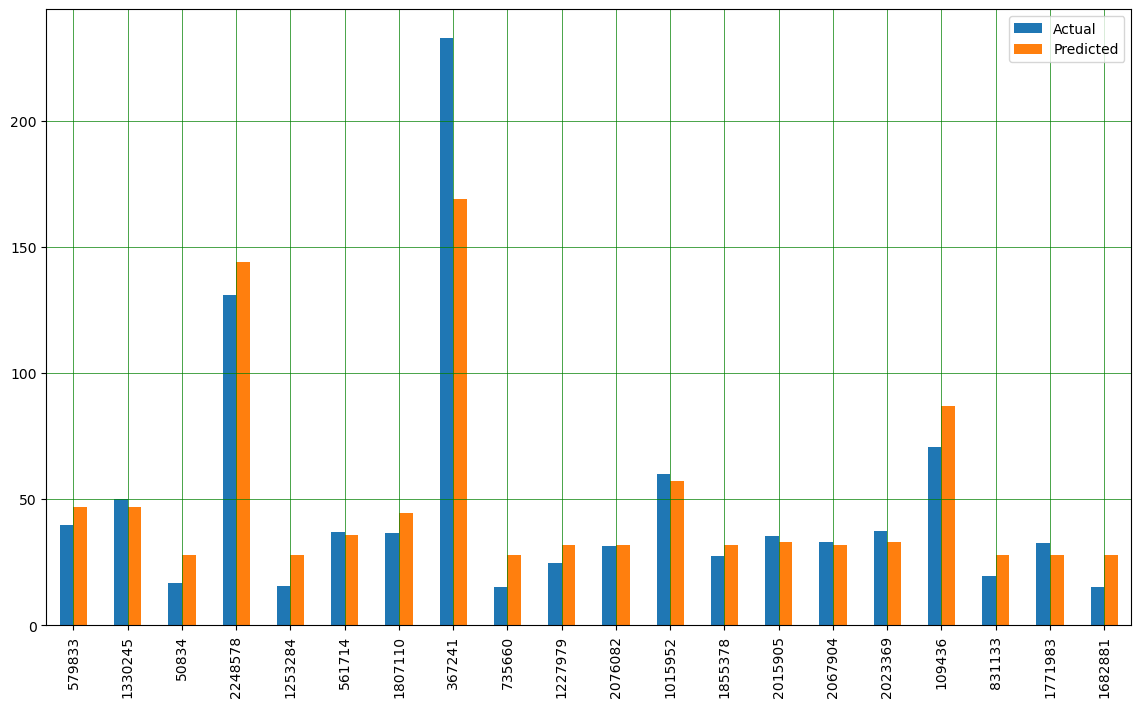

In [40]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [41]:
#Getting The R Squared Value
ad_score = r2_score(y_test, ada_trips)
print(ad_score)

0.7990506377336507


In [42]:
# Running The GradientBoostRegressor model
start_time = time.time()
gd_regression = GradientBoostingRegressor()
gd_regression = gd_regression.fit(x_train, y_train)
end_time = time.time()
gd_time = (end_time - start_time)
print(f"Time taken to train Gradient Boost model : {gd_time} seconds")

Time taken to train Gradient Boost model : 1531.2313694953918 seconds


In [43]:
gd_trips = gd_regression.predict(x_test)

In [44]:
predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': gd_trips.flatten()})
predictions

,Actual,Predicted
0,38.10,44.107137
1,24.19,23.813498
2,36.35,37.233190
3,23.37,23.641803
4,25.69,33.215073
...,...,...
2557898,29.00,32.023550
2557899,22.18,21.032382
2557900,21.16,23.842177
2557901,14.46,17.260682


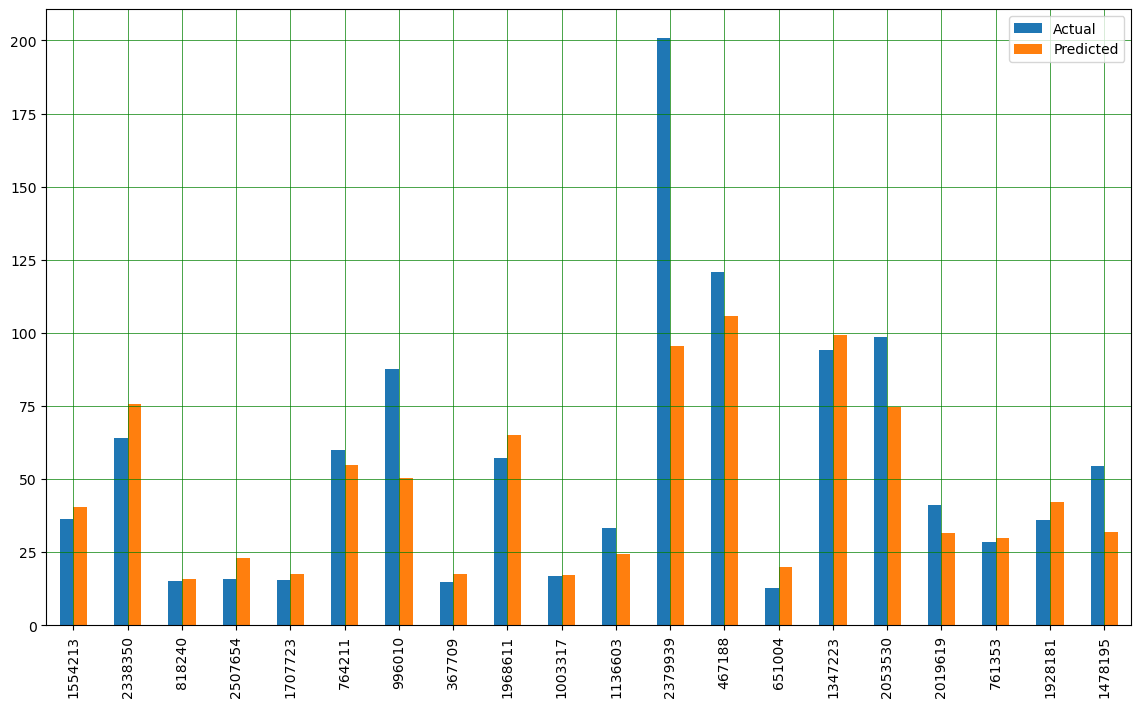

In [45]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [46]:
#Getting The R Squared Value
gd_score = r2_score(y_test, gd_trips)
print(gd_score)

0.8762103236854984


In [47]:
# Running The XGBRegressor model
start_time = time.time()
xgb_regression = XGBRegressor(objective ='reg:squarederror')
xgb_regression = xgb_regression.fit(x_train, y_train)
end_time = time.time()
xgb_time = (end_time - start_time)
print(f"Time taken to train XGBoost  model : {xgb_time} seconds")

Time taken to train XGBoost  model : 77.16423273086548 seconds


In [48]:
XGB_trips = xgb_regression.predict(x_test)

In [49]:
predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': XGB_trips.flatten()})
predictions

,Actual,Predicted
0,38.10,42.344780
1,24.19,27.997890
2,36.35,36.161201
3,23.37,22.383575
4,25.69,29.033096
...,...,...
2557898,29.00,29.803926
2557899,22.18,20.553808
2557900,21.16,21.281849
2557901,14.46,15.548802


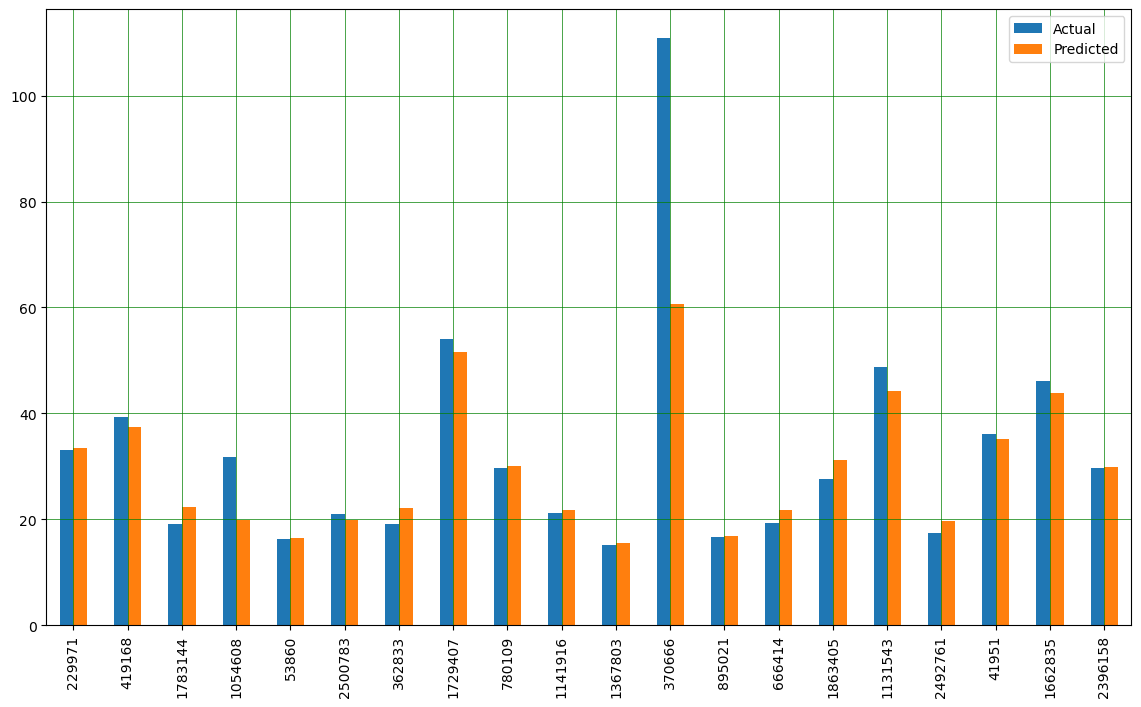

In [50]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [51]:
#Getting The R Squared Value
xgb_score = r2_score(y_test, XGB_trips)
print(xgb_score)

0.8892512325508417


In [52]:
# Creating Accuracy and Time Dataframe
r2 = [lm_score, dt_score, ad_score, gd_score, xgb_score]
tm = [lm_time, dt_time, ad_time, gd_time, xgb_time]
comp = pd.DataFrame({'Time': tm, 'Accu': r2})

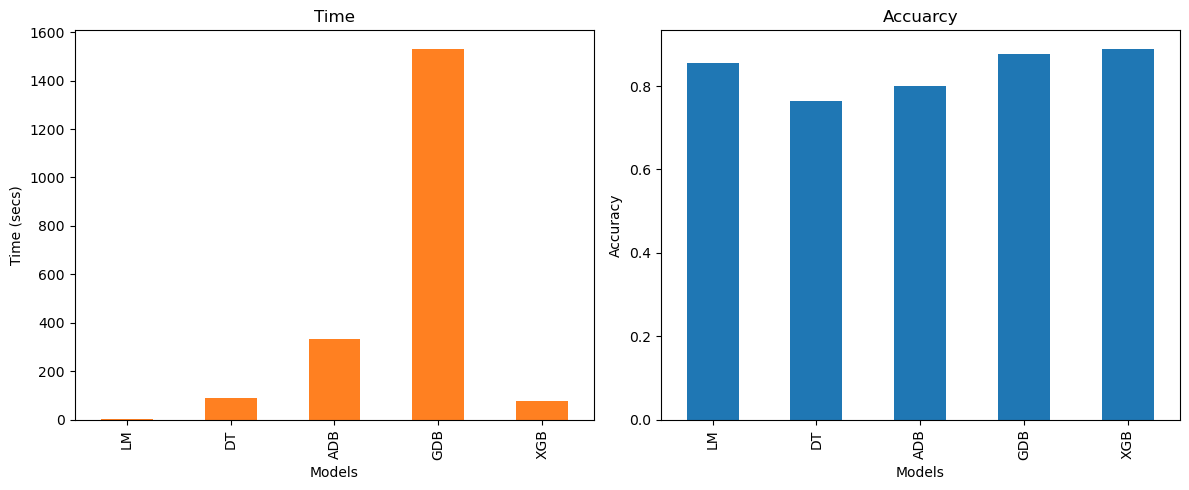

In [53]:
# Comparing All models based on time taken to implement and Accuracy

label = ['LM', 'DT', 'ADB', 'GDB', 'XGB']
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = comp['Time'].plot(kind='bar',title="Time",ax=axes[0],color = (1, 0.5, 0.13))
ax1 = comp['Accu'].plot(kind='bar',title="Accuarcy",ax=axes[1])
ax.set_ylabel("Time (secs)")
ax.set_xlabel('Models')
ax.set_xticklabels(label)
ax1.set_ylabel("Accuracy")
ax1.set_xlabel('Models')
ax1.set_xticklabels(label)
fig.tight_layout()

In [54]:
Distance = 1.9
PULocationID = 138
DOLocationID = 7
WeekDay = 6
Hour = 7

answer = xgb_regression.predict([[Distance,PULocationID,DOLocationID,WeekDay,Hour]])
predicted_fare = ["%.2f"% elem for elem in answer]

if PULocationID == 132:
    predictedfare = float(predicted_fare[0])
    fare= predictedfare + 1.25
    print(f'Your estimated fare is $',fare)
elif PULocationID == 138:
    predictedfare = float(predicted_fare[0])
    fare= predictedfare + 1.25
    print(f'Your estimated fare is $',fare)
else:
    print(f'Your estimated fare is $',predicted_fare[0])

Your estimated fare is $ 70.06
